In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/ADA_Judiciary")

In [3]:
cases_cleaned_judges = pd.read_csv(data_dir / "cases" / "cases_cleaned_judges.csv")

In [4]:
type_name_key = pd.read_csv(data_dir / "keys" / "type_name_key.csv")

In [5]:
print('Number of records in cleaned cases file for 2018: ' + str(len(cases_cleaned_judges)))
cases_cleaned_judges.head()

Number of records in cleaned cases file for 2018: 13724299


,female_defendant,female_petitioner,type_name,date_of_filing,date_first_list,case_duration_days,court_details,state_district,judge_category
0,0,0,1943,2018-01-01,2018-01-01,37.0,1-1-1,1-1,magistrate
1,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate
2,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate
3,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate
4,-1,0,1943,2018-01-01,2018-01-01,8.0,1-1-1,1-1,magistrate


In [6]:
cases_cleaned_judges.dtypes

,0
female_defendant,int64
female_petitioner,int64
type_name,int64
date_of_filing,object
date_first_list,object
case_duration_days,float64
court_details,object
state_district,object
judge_category,object


In [7]:
type_name_key.head()

,year,type_name,type_name_s,count
0,2010,1.0,(m) t.s.,18
1,2010,2.0,(sc),2
2,2010,3.0,..mact 166,97
3,2010,4.0,04 complaint cases,19
4,2010,5.0,04 criminal case,21


In [8]:
type_name_2018 = type_name_key[type_name_key['year'] == 2018]

In [9]:
print(len(type_name_2018))
type_name_2018.head()

7533


,year,type_name,type_name_s,count
55181,2018,1.0,(m) t.s.,167
55182,2018,2.0,(mac) money execution,5
55183,2018,3.0,0.s.(la),1
55184,2018,4.0,01 bail_application,355
55185,2018,5.0,01 criminal appeal,14


In [10]:
# Unique values in type_name_s
unique_values = type_name_2018['type_name_s'].unique()
print(unique_values)
print(f"Number of unique values: {len(unique_values)}")

['(m) t.s.' '(mac) money execution' '0.s.(la)' ... 'zilla panchayat act'
 'zima 457 cr.p.c.' 'zimma application']
Number of unique values: 7533


In [11]:
cases_merged_type = cases_cleaned_judges.merge(
    type_name_2018[['type_name', 'type_name_s']],
    how='left',
    on='type_name'
)

In [12]:
cases_merged_type.head()
cases_merged_type.isnull().sum()

,0
female_defendant,0
female_petitioner,0
type_name,0
date_of_filing,0
date_first_list,0
case_duration_days,0
court_details,0
state_district,0
judge_category,0
type_name_s,0


In [13]:
print(cases_merged_type.columns)

Index(['female_defendant', 'female_petitioner', 'type_name', 'date_of_filing',
       'date_first_list', 'case_duration_days', 'court_details',
       'state_district', 'judge_category', 'type_name_s'],
      dtype='object')


In [14]:
def clean_type_name(type_series, rare_threshold=10):
    """
    Cleans the 'type_name_s' column:
    - Lowercase and strip spaces
    - Remove punctuation
    - Standardize common abbreviations
    - Group rare cases into 'other'

    Parameters:
        type_series (pd.Series): Column with case type names
        rare_threshold (int): Minimum count to keep a type, else grouped as 'other'

    Returns:
        pd.Series: Cleaned type names
    """

    # 1. Lowercase and strip whitespace
    cleaned = type_series.str.lower().str.strip()

    # 2. Remove punctuation
    cleaned = cleaned.str.translate(str.maketrans('', '', string.punctuation))

    # 3. Standardize common abbreviations / variations
    abbreviation_map = {
        'crima': 'criminal misc appeal',
        'rcc': 'recovery civil case',
        'munci appeal': 'municipal appeal',
        'execution cases': 'execution case',
        'suit for declaration and partition': 'declaration/partition suit',
        'application for interim injunction': 'interim injunction'
        # Add more mappings as needed
    }

    cleaned = cleaned.replace(abbreviation_map, regex=True)

    # 4. Group rare types into 'other'
    counts = cleaned.value_counts()
    rare_types = counts[counts < rare_threshold].index
    cleaned = cleaned.apply(lambda x: 'other' if x in rare_types else x)

    return cleaned

# Example usage
cases_merged_type['type_name_s_clean'] = clean_type_name(cases_merged_type['type_name_s'], rare_threshold=10)

# Check unique values after cleaning
print(cases_merged_type['type_name_s_clean'].nunique())
print(cases_merged_type['type_name_s_clean'].value_counts().head(20))


3921
type_name_s_clean
cc                      1358141
cri case                 557572
scc                      440093
os                       353634
cr reg case              350840
criminal case            348581
bail application         345174
st                       297561
stc                      251115
sum                      225535
rct                      202026
ba                       188837
criminal misc            184837
complaint cases          182104
final report             161429
original suit            153783
crlmisc                  142719
motor vehc act           136236
criminal misc appeal     135442
ep                       133294
Name: count, dtype: int64


In [15]:
# Define a mapping dictionary
type_mapping = {
    'cc': 'criminal',
    'cri case': 'criminal',
    'criminal case': 'criminal',
    'cr reg case': 'criminal',
    'criminal misc': 'criminal',
    'criminal misc appeal': 'criminal',
    'bail application': 'bail/misc',
    'ba': 'bail/misc',
    'final report': 'bail/misc',
    'os': 'civil',
    'scc': 'civil',
    'st': 'civil',
    'stc': 'civil',
    'sum': 'civil',
    'rct': 'motor/special',
    'motor vehc act': 'motor/special',
    'complaint cases': 'motor/special',
    'ep': 'civil',
    # Add more mappings as needed, all other unmapped -> 'other'
}

# Apply mapping to your dataset
cases_merged_type['type_category'] = cases_merged_type['type_name_s_clean'].map(type_mapping)

# Fill unmapped values with 'other'
cases_merged_type['type_category'] = cases_merged_type['type_category'].fillna('other')

# Check results
cases_merged_type[['type_name_s_clean', 'type_category']].head(20)


,type_name_s_clean,type_category
0,criminal misc appeal,criminal
1,criminal misc appeal,criminal
2,criminal misc appeal,criminal
3,criminal misc appeal,criminal
4,criminal misc appeal,criminal
5,criminal misc appeal,criminal
6,criminal misc appeal,criminal
7,criminal misc appeal,criminal
8,criminal misc appeal,criminal
9,criminal misc appeal,criminal


In [16]:
cases_merged_type['type_category'].value_counts().head(20)

,count
type_category,
other,7871848
criminal,2935413
civil,1701232
bail/misc,695440
motor/special,520366


In [17]:
cases_merged_type.head()

,female_defendant,female_petitioner,type_name,date_of_filing,date_first_list,case_duration_days,court_details,state_district,judge_category,type_name_s,type_name_s_clean,type_category
0,0,0,1943,2018-01-01,2018-01-01,37.0,1-1-1,1-1,magistrate,cri.m.a.,criminal misc appeal,criminal
1,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,cri.m.a.,criminal misc appeal,criminal
2,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,cri.m.a.,criminal misc appeal,criminal
3,0,0,1943,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,cri.m.a.,criminal misc appeal,criminal
4,-1,0,1943,2018-01-01,2018-01-01,8.0,1-1-1,1-1,magistrate,cri.m.a.,criminal misc appeal,criminal


In [18]:
columns_to_drop = ['type_name', 'type_name_s', 'type_name_s_clean']

# Create a copy of the dataframe and start preparing the same for prediction modelling
df_cases = cases_merged_type.drop(columns=columns_to_drop, axis=1)

In [19]:
df_cases['court_details'] = df_cases['court_details'].astype(str).astype('category')
df_cases['state_district'] = df_cases['state_district'].astype(str).astype('category')
df_cases['judge_category'] = df_cases['judge_category'].astype(str).astype('category')
df_cases['type_category'] = df_cases['type_category'].astype(str).astype('category')

In [21]:
# Step 1: Convert, forcing invalid values (like '-1') to NaT
df_cases['date_of_filing'] = pd.to_datetime(df_cases['date_of_filing'], errors='coerce')
df_cases['date_first_list'] = pd.to_datetime(df_cases['date_first_list'], errors='coerce')

df_cases['date_of_filing'] = pd.to_datetime(df_cases['date_of_filing'])
df_cases['date_first_list'] = pd.to_datetime(df_cases['date_first_list'])

In [23]:
# Quick sanity check
df_cases.info()
df_cases.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13724299 entries, 0 to 13724298
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   female_defendant    int64         
 1   female_petitioner   int64         
 2   date_of_filing      datetime64[ns]
 3   date_first_list     datetime64[ns]
 4   case_duration_days  float64       
 5   court_details       category      
 6   state_district      category      
 7   judge_category      category      
 8   type_category       category      
dtypes: category(4), datetime64[ns](2), float64(1), int64(2)
memory usage: 602.4 MB


,female_defendant,female_petitioner,date_of_filing,date_first_list,case_duration_days,court_details,state_district,judge_category,type_category
0,0,0,2018-01-01,2018-01-01,37.0,1-1-1,1-1,magistrate,criminal
1,0,0,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,criminal
2,0,0,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,criminal
3,0,0,2018-01-01,2018-01-01,31.0,1-1-1,1-1,magistrate,criminal
4,-1,0,2018-01-01,2018-01-01,8.0,1-1-1,1-1,magistrate,criminal


<Axes: >

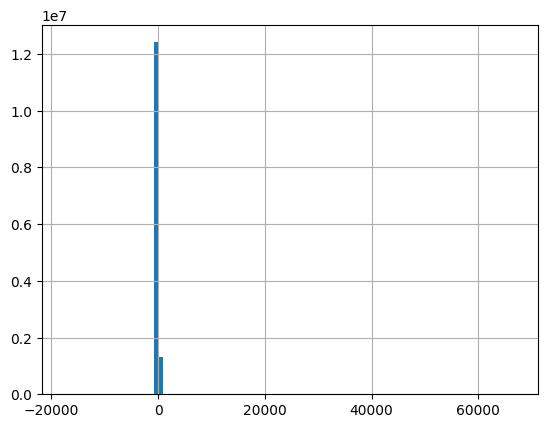

In [25]:
df_cases['case_duration_days'].hist(bins=100)

In [28]:
sum(df_cases['date_first_list'] < df_cases['date_of_filing'])

69091

<Axes: title={'center': 'Cases by Judge Category'}, ylabel='count'>

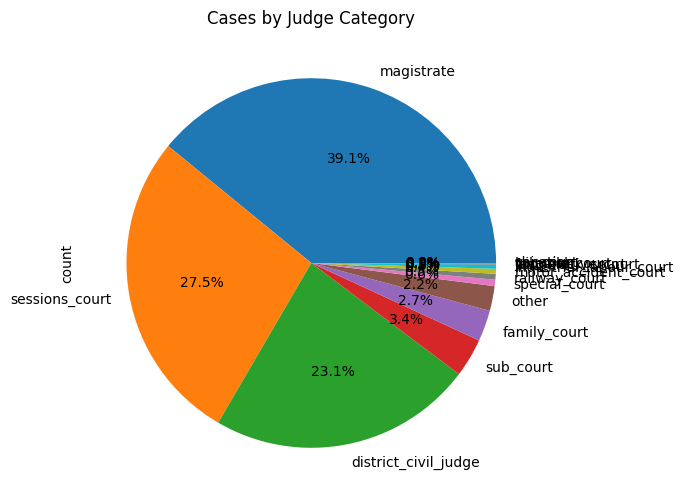

In [29]:
# Number of cases per judge category
df_cases['judge_category'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(6,6), title='Cases by Judge Category'
)


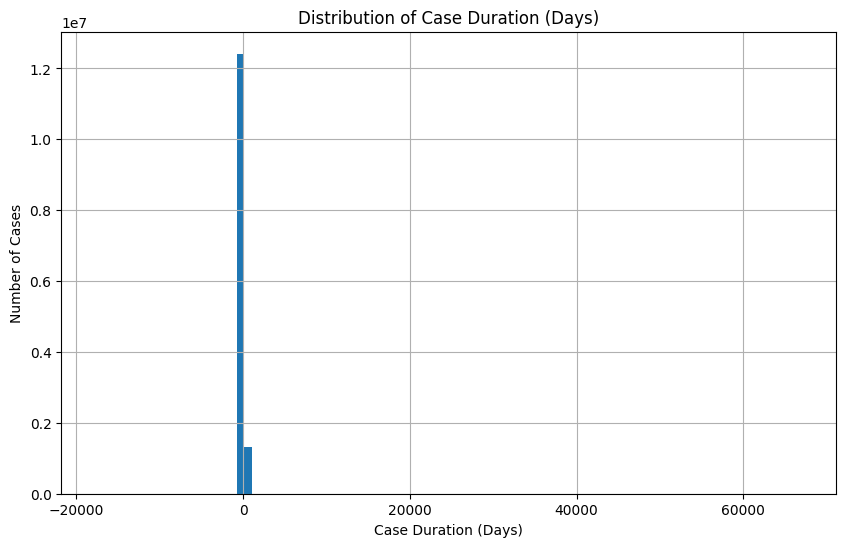

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_cases['case_duration_days'].hist(bins=100)
plt.title('Distribution of Case Duration (Days)')
plt.xlabel('Case Duration (Days)')
plt.ylabel('Number of Cases')
plt.show()


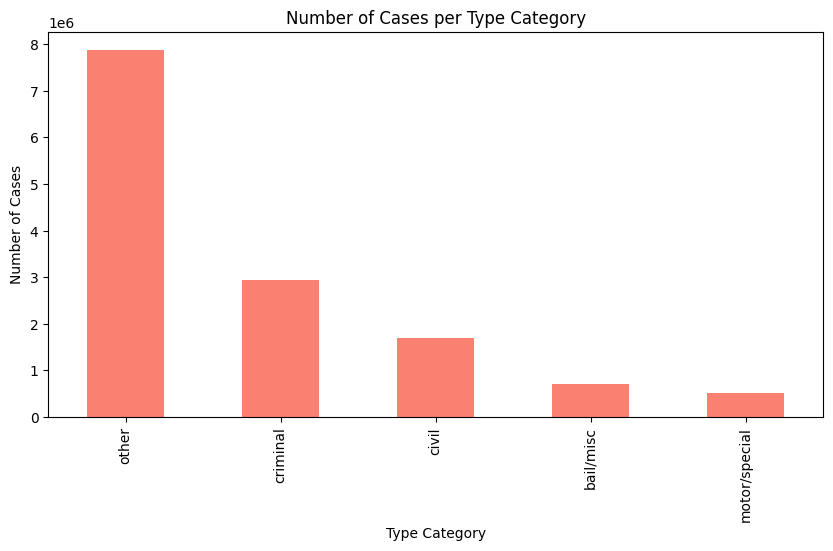

In [32]:
df_cases['type_category'].value_counts().plot.bar(figsize=(10,5), color='salmon')
plt.title('Number of Cases per Type Category')
plt.ylabel('Number of Cases')
plt.xlabel('Type Category')
plt.show()

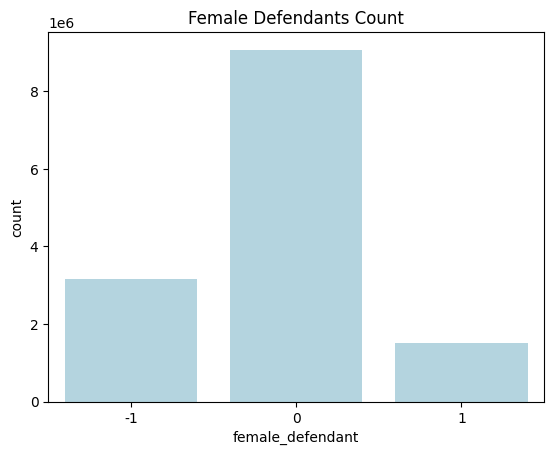

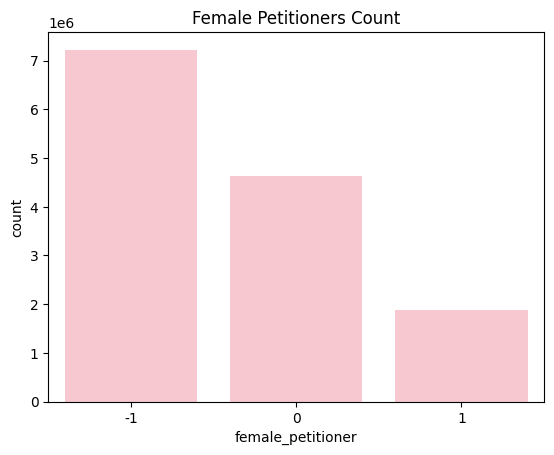

In [33]:
import seaborn as sns

sns.countplot(data=df_cases, x='female_defendant', color='lightblue')
plt.title('Female Defendants Count')
plt.show()

sns.countplot(data=df_cases, x='female_petitioner', color='pink')
plt.title('Female Petitioners Count')
plt.show()

In [24]:
df_cases.to_csv(data_dir / "cases" / "df_cases.csv", index=False)